# The Walk Forward ARI Model of Time Series
- An ARI model using lag number 7 and differenced once
- Walk Forward Method
- Trained and tested on a 63+18 dataset, step = 7
- Evaluated with average RMSE, MAE, MAPE

In [1]:
import pandas as pd
import numpy as np
import random
from statsmodels.tsa.stattools import pacf
from matplotlib.pyplot import figure
from statsmodels.tsa.arima.model import ARIMA
# !pip install scikit-learn==0.24
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# import data
df = pd.read_csv("JointData.csv", index_col = False)
df = df[["date","cases"]]  # use only daily increment of cases to forcast
df.reset_index(drop=True, inplace=True)
df.head()

,date,cases
0,2020-07-27,207.0
1,2020-07-28,128.0
2,2020-07-29,126.0
3,2020-07-30,105.0
4,2020-07-31,112.0


# Data Smoothing
- Remove day of week effect by replace $y_t$ with an average of 7 previous days(inclusive)
    - Each value is an average of data from all 7 different weekdays, thud day of week effect removed

In [4]:
# create a time series of cases, each value is an average of 7 previous days(include the current date)
# starting from the 7th day:
cases_ave = []
for i in range(6,len(df)):
    # remove day of week effect
    temp = np.mean(df.cases.iloc[i-6:i+1])  # 6 previous days and the exact date, 7 days' average
    cases_ave.append(temp)

df = df.iloc[6:].reset_index(drop = True)  # start on day 7, update index
df['case'] = cases_ave

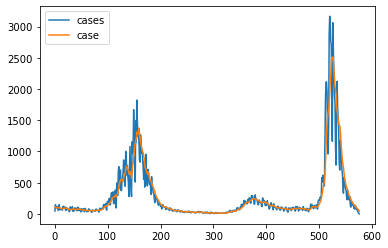

In [5]:
df.plot()
plt.show()  # cases- original data, case- smoothed version w/o day of week effect

In [6]:
df.head()

,date,cases,case
0,2020-08-02,46.0,114.142857
1,2020-08-03,147.0,105.571429
2,2020-08-04,91.0,100.285714
3,2020-08-05,114.0,98.571429
4,2020-08-06,116.0,100.142857


In [7]:
# work with time series:
df1 = df[["date", "case"]]
# df1["date"] = pd.to_datetime(df1["date"])  # convert to datatime
df1.set_index("date", inplace=True)
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 577 entries, 2020-08-02 to 2022-03-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   case    577 non-null    float64
dtypes: float64(1)
memory usage: 9.0+ KB


In [8]:
df1 = df1.to_dict()['case']  # convert to dict in order to convert to series

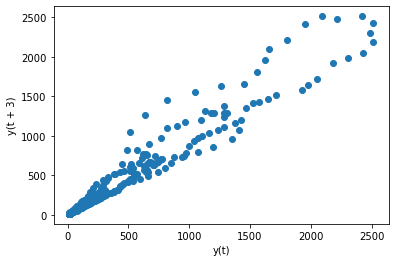

In [9]:
# check the lag
s = pd.Series(df1)
pd.plotting.lag_plot(s, lag = 3)  # larger lag --> weaker correlation
plt.show()

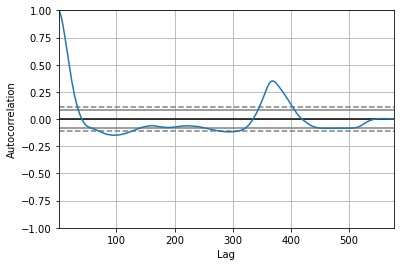

In [10]:
# autocorrelation plot
pd.plotting.autocorrelation_plot(s)
plt.show()

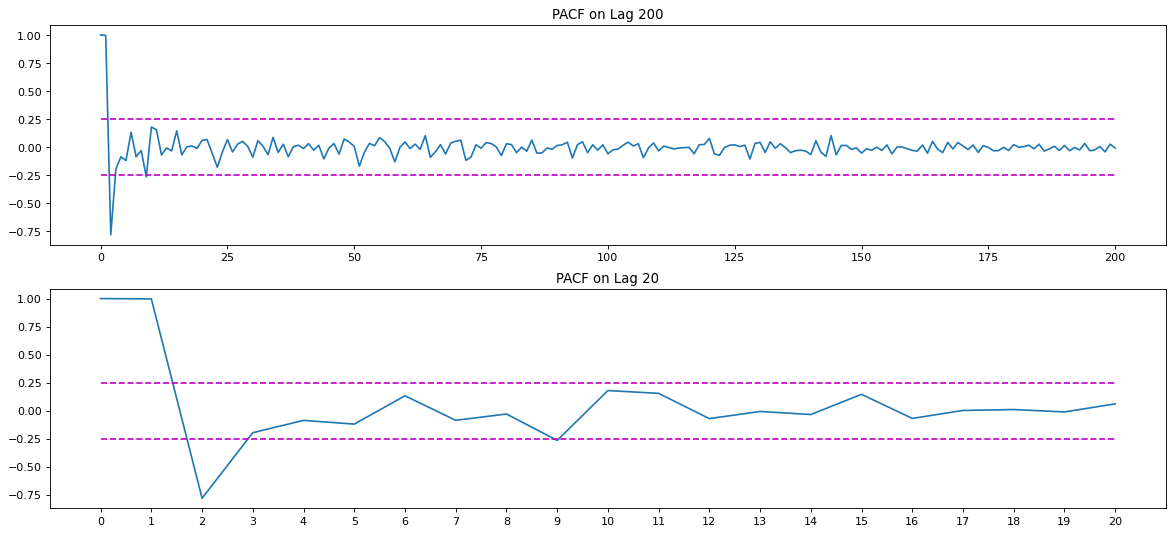

In [11]:
# calculate pacf of smoothed case
pacf_value = pacf(df.case,nlags=200,method="ols",alpha=None)
# caculate 95% confidence interval
up = np.mean(pacf_value) + 1.96 * np.std(pacf_value)
lo = np.mean(pacf_value) - 1.96 * np.std(pacf_value)
# plot
figure(figsize=(18, 8), dpi=80)
plt.subplot(2, 1, 1)
plt.plot(pacf_value)
plt.title("PACF on Lag 200")
plt.plot(range(len(pacf_value)),np.repeat(up,len(pacf_value)), 'm--')
plt.plot(range(len(pacf_value)),np.repeat(lo,len(pacf_value)), 'm--')

plt.subplot(2, 1, 2)
plt.plot(pacf_value[0:21])
plt.title("PACF on Lag 20")
plt.plot(range(0,21),np.repeat(up,len(pacf_value[0:21])), 'm--')
plt.plot(range(0,21),np.repeat(lo,len(pacf_value[0:21])), 'm--')
plt.xticks(range(0,21))
plt.show()

## Evaluation with RMSE, MAE, MAPE

In [12]:
# evaluate RMSE for each step in forcasting
def evaluate_forecasts(test, forecasts):
    rmse = np.sqrt(mean_squared_error(test, forecasts))
    mae = mean_absolute_error(test, forecasts)
    test = np.array(test)
    forecasts = np.array(forecasts)
    mape = np.mean(np.abs((test - forecasts)/test))*100
    return rmse, mae, mape

# Training Model

### AutoRegression
- assume observations from previous time steps are useful to predict values at latter time steps
    - true for Time Series
- choose a proper lag
    - use lag as variable
    - if all lag variables show no correlation with output, then the time series problem could be not predictable
    - Use the same lag number for AR, LSTM, and combined, for comparison

$$y_t = \phi_1 y_{t-1} + \phi_2 y_{t-2} + ... + \phi_p y_{t-p} + \epsilon_t$$
where $p$ is the lag number, $p = 7$

# A Single Trial as Demo

In [13]:
# given historical observations (t, t-1, t-2, … t-n+1) forecast t+1(future 1 day)
n_lag = 7  # number of lag, use 7 past days
n_seq = 1  # predict 1 future days
train_size = 63  # train set size
test_size = 18 # test set size
X = s.values.tolist()
train, test = X[-(train_size+test_size):-test_size], X[-test_size:]

In [14]:
model = ARIMA(train, order = (n_lag,1,0))  # AR, I, MA
model = model.fit()

In [15]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   63
Model:                 ARIMA(7, 1, 0)   Log Likelihood                -329.399
Date:                Mon, 15 Aug 2022   AIC                            674.798
Time:                        01:24:23   BIC                            691.815
Sample:                             0   HQIC                           681.479
                                 - 63                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7734      0.105      7.367      0.000       0.568       0.979
ar.L2          0.0617      0.138      0.448      0.654      -0.209       0.332
ar.L3          0.1093      0.200      0.545      0.586      -0.284       0.502
ar.L4         -0.1251      0.200     -0.624      0.533      -0.518       0.268
ar.L5         -0.0779      0.184     -0.423      0.673      -0.439       0.283
ar.L6          0.0833      0.188      0.443      0.658      -0.286       0.452
ar.L7          0.0454      0.128      0.355      0.722      -0.205       0.296
sigma2      2358.6499    353.892      6.665      0.000    1665.034    3052.266
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                15.01
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.61   Skew:                            -0.42
Prob(H) (two-sided):                  0.27   Kurtosis:                         5.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Walk Forward Method

In [16]:
history = [x for x in train]
predictions = []
for t in range(len(test)):
    model = ARIMA(history, order=(7,1,0))
    model = model.fit()
    output = model.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=260.476278, expected=255.857143
predicted=242.688801, expected=239.000000
predicted=225.101159, expected=213.857143
predicted=190.516556, expected=195.428571
predicted=177.387276, expected=187.714286
predicted=178.995465, expected=174.428571
predicted=163.941886, expected=154.142857
predicted=138.801637, expected=146.000000
predicted=136.525389, expected=141.571429
predicted=134.982510, expected=126.428571
predicted=115.606259, expected=119.428571
predicted=113.745594, expected=105.285714
predicted=91.101310, expected=97.142857
predicted=89.832356, expected=86.714286
predicted=77.878201, expected=80.142857
predicted=74.355697, expected=72.142857
predicted=65.229105, expected=60.428571
predicted=50.570717, expected=41.714286


In [17]:
evaluate_forecasts(predictions, history[-test_size:])

(6.680743508368934, 6.085083968002089, 5.113282855786318)

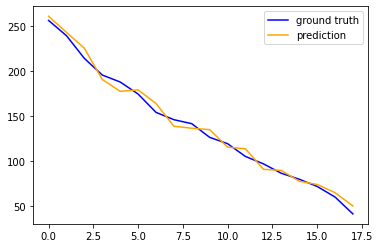

In [18]:
plt.plot(s.values[-test_size:], color = 'blue', label = "ground truth")
plt.plot(predictions, color = 'orange', label = "prediction")
plt.legend()
plt.show()

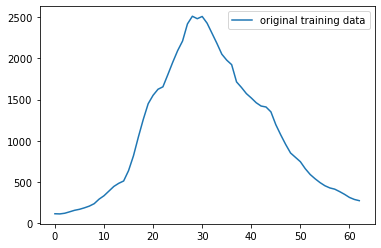

In [19]:
original_train = s[-(test_size+train_size):-test_size]
x = range(0,len(original_train))
plt.plot(x,original_train, label = "original training data")
plt.legend()
plt.show()

Notice: absence of a periodic trend. As a result, including more data does not always give us a better result
- how does the algorithm work on different training and testing sets, given the same size of each?

# Evaluate AR Method on Various Training & Testing Sets

In [20]:
n_step = 7  # step size
n_lag = 7  # number of lag, use 7 past days
n_seq = 1  # predict 1 future days
train_size = 63  # train set size
test_size = 18 # test set size

In [21]:
# for each date t
    # use [t, t + train_size) as training set
    # use [t + train_size, t + train_size + test_size) as testing set
    # evaluate by calculating RMSE

# holder for rmse:
RMSE = []
MAE = []
MAPE = []
X = s.values.tolist()
for i in range(0, len(df)-(train_size+test_size)+1, n_step):  # len(df)-(train_size+test_size)+1
    # cut a data trial from original dataset
    train, test = X[i:i+train_size], X[i+train_size:i+train_size+test_size]
    history = [x for x in train]
    predictions = []
    # walk forward
    for t in range(len(test)):
        model = ARIMA(history, order=(7,1,0))
        model = model.fit()
        output = model.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
    # evaluate
    rmse, mae, mape = evaluate_forecasts(predictions, history[-test_size:])
    RMSE.append(rmse)
    MAE.append(mae)
    MAPE.append(mape)

In [22]:
# create a data frame of 
    # date i
    # rmse of data trial starting on date i
date = [df['date'][i] for i in range(0, len(df)-(train_size+test_size)+1, n_step)]
AR_evaluate = {'date': date,
              'rmse': RMSE, 'mae': MAE, 'mape': MAPE}
AR_evaluate = pd.DataFrame(AR_evaluate)
AR_evaluate

,date,rmse,mae,mape
0,2020-08-02,1.509372,1.202350,2.242045
1,2020-08-09,1.877983,1.537344,2.812307
2,2020-08-16,3.618109,2.833914,4.123920
3,2020-08-23,5.348007,4.774668,5.193778
4,2020-08-30,5.934107,5.186301,4.095316
...,...,...,...,...
66,2021-11-07,95.592727,73.132176,3.862022
67,2021-11-14,63.567384,41.471113,3.176276
68,2021-11-21,33.061858,20.437123,2.508938
69,2021-11-28,13.459149,10.306192,2.751834


In [23]:
print("The average Root Mean Square Error for AR(7) algorithm is {}".format(np.mean(AR_evaluate['rmse'])))
print("The average Mean Absolute Error for AR(7) algorithm is {}".format(np.mean(AR_evaluate['mae'])))
print("The average Mean Absolute Percentage Error for AR(7) algorithm is {}".format(np.mean(AR_evaluate['mape'])))
print("\n")
print("The maximum of all RMSE is {}".format(max(RMSE)))
print("The maximum of all MAE is {}".format(max(MAE)))
print("The maximum of all MAPE is {}".format(max(MAPE)))

The average Root Mean Square Error for AR(7) algorithm is 15.672321854680716
The average Mean Absolute Error for AR(7) algorithm is 12.179544653661775
The average Mean Absolute Percentage Error for AR(7) algorithm is 3.7101829828583095


The maximum of all RMSE is 99.91733656357263
The maximum of all MAE is 83.0617998371079
The maximum of all MAPE is 7.269472530752595


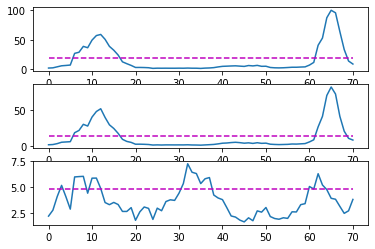

In [24]:
# plot RMSE, visualize with its 75% quantile
fig, (ax1,ax2,ax3) = plt.subplots(3, 1)

ax1.plot(RMSE)
up = np.quantile(RMSE, 0.75)
ax1.plot(range(len(AR_evaluate)),np.repeat(up,len(AR_evaluate)), 'm--')

ax2.plot(MAE)
up = np.quantile(MAE, 0.75)
ax2.plot(range(len(AR_evaluate)),np.repeat(up,len(AR_evaluate)), 'm--')

ax3.plot(MAPE)
up = np.quantile(MAPE, 0.75)
ax3.plot(range(len(AR_evaluate)),np.repeat(up,len(AR_evaluate)), 'm--')

plt.show()

From the graph, we observed that the abnormalty of RMSE and MAE generally corresponds. MAPE is always below $20%$, thus conventionally considered as good.

# Identify and Visualize the Outliers

## The Maximum RMSE

In [25]:
# locate where the maximum RMSE take place
maximum = max(RMSE)
max_index = RMSE.index(maximum)*n_step
# print out the dates around maximum RMSE
df['date'][max_index]

'2021-10-31'

In [26]:
# fit the model on maximum RMSE
X = s.values.tolist()[max_index:max_index+(train_size+test_size)]  # smoothed data
train, test = X[-(train_size+test_size):-test_size], X[-test_size:]
history = [x for x in train]
predictions = []
for t in range(len(test)):
    model = ARIMA(history, order=(7,1,0))
    model = model.fit()
    output = model.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=1689.564940, expected=1655.428571
predicted=1702.291559, expected=1802.857143
predicted=2008.618009, expected=1953.571429
predicted=2165.707405, expected=2094.428571
predicted=2151.028955, expected=2211.142857
predicted=2333.155360, expected=2419.142857
predicted=2575.841341, expected=2512.000000
predicted=2581.372949, expected=2482.142857
predicted=2421.293629, expected=2509.285714
predicted=2665.354415, expected=2427.714286
predicted=2291.458667, expected=2305.142857
predicted=2277.553565, expected=2182.428571
predicted=2132.580009, expected=2051.285714
predicted=1905.934009, expected=1979.000000
predicted=1942.609011, expected=1924.571429
predicted=1899.209036, expected=1715.000000
predicted=1522.475086, expected=1647.571429
predicted=1581.767553, expected=1573.000000


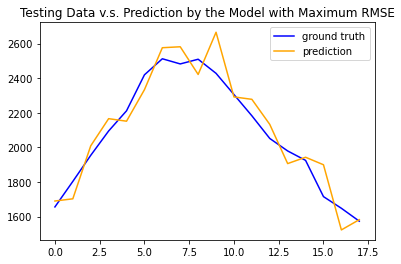

In [27]:
# visualize the model on maximum RMSE
plt.plot(history[-test_size:], color = 'blue', label = "ground truth")
plt.plot(predictions, color = 'orange', label = "prediction")
plt.title("Testing Data v.s. Prediction by the Model with Maximum RMSE")
plt.legend()
plt.show()

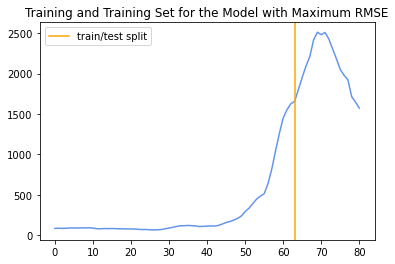

In [28]:
plt.plot(X, color = 'cornflowerblue')
# visualize the split of test/train
plt.axvline(x = train_size, color = 'orange', label = 'train/test split')
plt.title("Training and Training Set for the Model with Maximum RMSE")
plt.legend()
plt.show()

## The Minimum RMSE

- check where the model works the best

In [29]:
# locate where the minimum RMSE take place
minimum = min(RMSE)
min_index = RMSE.index(minimum)*n_step
# print out the dates around minimum RMSE
df['date'][min_index]

'2021-04-04'

In [30]:
# fit the model on maximum RMSE
X = s.values.tolist()[min_index:min_index+(train_size+test_size)]  # smoothed data
train, test = X[-(train_size+test_size):-test_size], X[-test_size:]
history = [x for x in train]
predictions = []
for t in range(len(test)):
    model = ARIMA(history, order=(7,1,0))
    model = model.fit()
    output = model.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=11.163422, expected=12.571429
predicted=13.646528, expected=13.571429
predicted=13.799308, expected=13.857143
predicted=14.451402, expected=13.857143
predicted=13.753823, expected=11.714286
predicted=10.868302, expected=11.571429
predicted=11.152359, expected=12.000000
predicted=12.348132, expected=12.428571
predicted=12.674168, expected=12.857143
predicted=12.866305, expected=11.857143
predicted=11.244760, expected=11.142857
predicted=11.372972, expected=11.714286
predicted=11.873946, expected=11.428571
predicted=11.643830, expected=11.428571
predicted=11.251172, expected=11.571429
predicted=11.179044, expected=11.857143
predicted=12.305057, expected=14.428571
predicted=15.535779, expected=14.857143


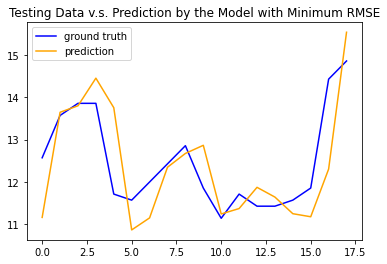

In [31]:
# visualize the model on maximum RMSE
plt.plot(history[-test_size:], color = 'blue', label = "ground truth")
plt.plot(predictions, color = 'orange', label = "prediction")
plt.title("Testing Data v.s. Prediction by the Model with Minimum RMSE")
plt.legend()
plt.show()

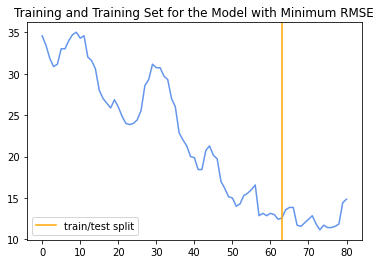

In [32]:
plt.plot(X, color = 'cornflowerblue')
# visualize the split of test/train
plt.axvline(x = train_size, color = 'orange', label = 'train/test split')
plt.title("Training and Training Set for the Model with Minimum RMSE")
plt.legend()
plt.show()